In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# 1. Load the Dataset
from sklearn.neural_network import MLPRegressor
import shap

In [5]:
df = pd.read_csv('Numerical Features Continous Outcome.csv')
df.head()

,Unnamed: 0,Annual_Income,Credit_Score,Debt_to_Income,Employment_Length,Age,Loan_Approval
0,0,65581.311290,505.502450,0.729998,12.762891,73,0.476365
1,1,120317.859109,483.101653,0.184512,9.185849,38,0.507581
2,2,99539.424472,396.884652,0.346640,19.289970,18,0.387672
3,3,86872.555999,633.996669,0.663281,4.379569,69,0.677483
4,4,44821.770842,562.143288,0.482089,11.757128,20,0.306824


In [7]:
df = df.drop(df.columns[[0]], axis=1)

In [9]:
df

,Annual_Income,Credit_Score,Debt_to_Income,Employment_Length,Age,Loan_Approval
0,65581.311290,505.502450,0.729998,12.762891,73,0.476365
1,120317.859109,483.101653,0.184512,9.185849,38,0.507581
2,99539.424472,396.884652,0.346640,19.289970,18,0.387672
3,86872.555999,633.996669,0.663281,4.379569,69,0.677483
4,44821.770842,562.143288,0.482089,11.757128,20,0.306824
...,...,...,...,...,...,...
9995,111477.318883,782.371246,0.952275,15.080678,39,0.916532
9996,115263.339335,325.747676,0.747824,15.290539,40,0.594636
9997,119937.251928,467.034158,0.019456,5.391389,69,0.413762
9998,67761.359280,543.826004,0.401005,8.686395,53,0.373033


In [11]:
X = df.drop('Loan_Approval', axis=1)
y = df['Loan_Approval']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
X_test_original = X_test.copy()

In [17]:
X_test_original

,Annual_Income,Credit_Score,Debt_to_Income,Employment_Length,Age
6252,62060.319343,353.290689,0.968948,11.586947,45
4684,103673.003188,734.158798,0.195106,15.575252,25
1731,89270.104448,414.860361,0.989355,11.385730,23
4742,33381.071927,743.248106,0.128248,6.649651,34
4521,84826.122827,818.050800,0.354751,16.913153,75
...,...,...,...,...,...
6412,111374.338925,689.483428,0.999598,5.417904,46
8285,110493.190826,603.585807,0.957609,12.825315,79
7853,58096.519289,554.791132,0.773801,15.547266,73
1095,46770.163041,472.984665,0.009994,3.741765,51


In [19]:
Q1 = X_train.quantile(0.25)
Q3 = X_train.quantile(0.75)
IQR = Q3 - Q1
X_train = X_train[~((X_train < (Q1 - 1.5 * IQR)) | (X_train > (Q3 + 1.5 * IQR))).any(axis=1)]
y_train = y_train[X_train.index] 

In [15]:
# def clip_outliers(df, lower_quantile=0.01, upper_quantile=0.99, ref_bounds=None):
    
#     df_clipped = df.copy()
#     bounds = {} if ref_bounds is None else ref_bounds

#     for col in df.columns:
#         if ref_bounds is None:
#             lower = df[col].quantile(lower_quantile)
#             upper = df[col].quantile(upper_quantile)
#             bounds[col] = (lower, upper)
#         else:
#             lower, upper = ref_bounds[col]
#         df_clipped[col] = df_clipped[col].clip(lower, upper)
#     return df_clipped, bounds

In [17]:
# X_train, train_bounds = clip_outliers(X_train, lower_quantile=0.01, upper_quantile=0.75, ref_bounds=None)

# # Now, apply the same outlier clipping on the test data using the bounds calculated from training data.
# X_test, _ = clip_outliers(X_test, lower_quantile=0.01, upper_quantile=0.95, ref_bounds=train_bounds)

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
mlp = MLPRegressor(
        hidden_layer_sizes=(128, 64),    # Two hidden layers: first with 100 neurons, second with 50 neurons
        activation='relu',               # 'relu' activation function for nonlinear mapping
        solver='adam',                   # 'adam' optimizer for stochastic gradient descent
        alpha=0.001,                     # L2 regularization term to prevent overfitting
        learning_rate='adaptive',        # The learning rate adapts based on performance during training
        learning_rate_init=0.001,        # Initial learning rate used in training# Exponent for the inverse scaling of learning rate (used if solver='sgd')
        max_iter=500,                   # Maximum number of iterations for training
        shuffle=True,                    # Shuffles samples in each iteration to help convergence
        random_state=1,                  # Seed for reproducibility
    ).fit(X_train_scaled, y_train)

In [25]:
train_losses = []
test_losses = []
epochs = 50  # Number of epochs (iterations)

for epoch in range(epochs):
    # Train for one epoch; note we are NOT reassigning mlp here!
    mlp.fit(X_train_scaled, y_train)
    train_losses.append(mlp.loss_)  # Record training loss

    # Calculate test loss (using MSE)
    y_test_pred = mlp.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_test_pred)
    test_losses.append(mse)

    print(f"Epoch {epoch+1}/{epochs}: Train Loss = {mlp.loss_:.4f}, Test MSE = {mse:.4f}")
    


Epoch 1/50: Train Loss = 0.0003, Test MSE = 0.0002
Epoch 2/50: Train Loss = 0.0003, Test MSE = 0.0002
Epoch 3/50: Train Loss = 0.0003, Test MSE = 0.0002
Epoch 4/50: Train Loss = 0.0003, Test MSE = 0.0002
Epoch 5/50: Train Loss = 0.0003, Test MSE = 0.0002
Epoch 6/50: Train Loss = 0.0003, Test MSE = 0.0002
Epoch 7/50: Train Loss = 0.0003, Test MSE = 0.0002
Epoch 8/50: Train Loss = 0.0003, Test MSE = 0.0002
Epoch 9/50: Train Loss = 0.0003, Test MSE = 0.0002
Epoch 10/50: Train Loss = 0.0003, Test MSE = 0.0002
Epoch 11/50: Train Loss = 0.0003, Test MSE = 0.0002
Epoch 12/50: Train Loss = 0.0003, Test MSE = 0.0002
Epoch 13/50: Train Loss = 0.0003, Test MSE = 0.0002
Epoch 14/50: Train Loss = 0.0003, Test MSE = 0.0002
Epoch 15/50: Train Loss = 0.0003, Test MSE = 0.0002
Epoch 16/50: Train Loss = 0.0003, Test MSE = 0.0002
Epoch 17/50: Train Loss = 0.0003, Test MSE = 0.0002
Epoch 18/50: Train Loss = 0.0003, Test MSE = 0.0002
Epoch 19/50: Train Loss = 0.0003, Test MSE = 0.0002
Epoch 20/50: Train Lo

In [27]:
y_pred = mlp.predict(X_test_scaled)

In [29]:
y_pred

array([0.41613626, 0.64358868, 0.62483732, ..., 0.50919269, 0.11691892,
       0.77549739])

In [31]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on test set: {mse}")

Mean Squared Error on test set: 0.00018957242081388736


In [33]:
# mse   = mean_squared_error(y_test, y_pred)
rmse  = np.sqrt(mse)  # Calculate RMSE from MSE
r2    = r2_score(y_test, y_pred)
mae   = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared: {r2:.4f}")

Mean Absolute Error (MAE): 0.0109
Root Mean Squared Error (RMSE): 0.0138
R-squared: 0.9958


In [35]:
predictions_df = pd.DataFrame({'Predicted_Label': y_pred})

In [37]:
merged_df = pd.concat([X_test_original.reset_index(drop=True), predictions_df.reset_index(drop=True)], axis=1)

In [39]:
merged_df

,Annual_Income,Credit_Score,Debt_to_Income,Employment_Length,Age,Predicted_Label
0,62060.319343,353.290689,0.968948,11.586947,45,0.416136
1,103673.003188,734.158798,0.195106,15.575252,25,0.643589
2,89270.104448,414.860361,0.989355,11.385730,23,0.624837
3,33381.071927,743.248106,0.128248,6.649651,34,0.263829
4,84826.122827,818.050800,0.354751,16.913153,75,0.687179
...,...,...,...,...,...,...
1995,111374.338925,689.483428,0.999598,5.417904,46,0.864307
1996,110493.190826,603.585807,0.957609,12.825315,79,0.856509
1997,58096.519289,554.791132,0.773801,15.547266,73,0.509193
1998,46770.163041,472.984665,0.009994,3.741765,51,0.116919


In [46]:
# merged_df.to_csv('Statistical Dataset for Numerical Features and Continous Outcome.csv', index=False)

In [41]:
import statsmodels.api as sm
from scipy import stats

features = ['Annual_Income', 'Credit_Score', 'Debt_to_Income', 'Employment_Length', 'Age']
DV = 'Predicted_Label'

scaler = StandardScaler()
X_std = scaler.fit_transform(merged_df[features])
# Convert back to DataFrame for easier manipulation.
X_std_df = pd.DataFrame(X_std, columns=features)

# Define the target
y = merged_df[DV]

# # Add an intercept (constant) to the standardized features.
X_std_const = sm.add_constant(X_std_df)

# # ----------------------------
# # 3. Fit a Multiple Linear Regression Model
# # ----------------------------
model_std = sm.OLS(y, X_std_const)
results_std = model_std.fit()
print(results_std.summary())



scaler_y = StandardScaler()
y_std = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Add an intercept term to the standardized independent variables
X_std_const = sm.add_constant(X_std_df)

# ----------------------------
# 3. Fit the OLS Regression Model on Standardized Data
# ----------------------------
model_std = sm.OLS(y_std, X_std_const)
results_std = model_std.fit()
print("\nOLS Regression Summary on Standardized Data:")
print(results_std.summary())

# Extract Beta Weights (standardized coefficients) excluding the intercept.
beta_weights = results_std.params.drop('const')
print("\nBeta Weights (Standardized Coefficients):")
print(beta_weights)


                            OLS Regression Results                            
Dep. Variable:        Predicted_Label   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 3.023e+04
Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                        22:38:08   Log-Likelihood:                 4590.6
No. Observations:                2000   AIC:                            -9169.
Df Residuals:                    1994   BIC:                            -9136.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.5020      0.00

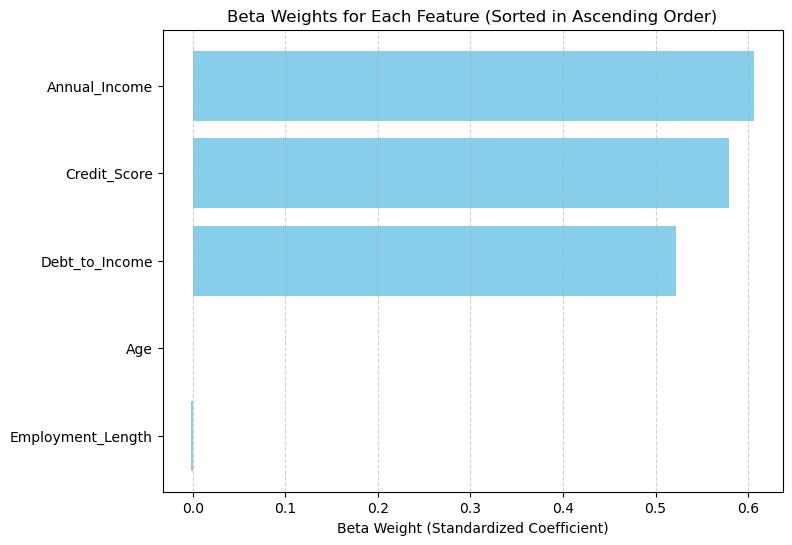

In [43]:
beta_weights_sorted = beta_weights.sort_values(ascending=True)

# Plot the sorted beta weights
plt.figure(figsize=(8, 6))
plt.barh(beta_weights_sorted.index, beta_weights_sorted.values, color='skyblue')
plt.xlabel("Beta Weight (Standardized Coefficient)")
plt.title("Beta Weights for Each Feature (Sorted in Ascending Order)")
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.show()

In [3]:
def compute_feature_recovery_metrics(gt, flagged, ranking):
    """
    Compute TP, FP, FN, Precision, Recall, FDR, and Top-1 Match for feature recovery.

    Parameters
    ----------
    gt : set
        Ground-truth causal features.
    flagged : list or set
        Features your method flagged as important (e.g., top‑k from ranking).
    ranking : list
        Ordered list of features by descending effect size.

    Returns
    -------
    pd.DataFrame
        Single-row DataFrame with the metrics.
    """
    tp = set(gt) & set(flagged)
    fp = set(flagged) - set(gt)
    fn = set(gt) - set(flagged)

    precision = len(tp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    recall    = len(tp) / len(gt)        if len(gt)              else 0.0
    fdr       = len(fp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    top1      = 1 if ranking and ranking[0] in gt else 0

    metrics = {
        "TP":           ", ".join(sorted(tp)),
        "FP":           ", ".join(sorted(fp)),
        "FN":           ", ".join(sorted(fn)),
        "Precision":     precision,
        "Recall":        recall,
        "FDR":           fdr,
        "Top-1 Match":   top1
    }
    return pd.DataFrame([{
        "Precision": precision,
        "Recall": recall,
        "FDR": fdr,
        "Top-1 Match": top1
    }])



if __name__ == "__main__":
    # Example:
    GT = {"annual_income", "credit_score", "debt_to_income"}
    ranking = [
        "annual_income",
        "credit_score",
        "debt_to_income",
        "employment_length",
        "Age"
    ]
    flagged = ranking[:3]  # e.g. top‑3 features

    df_metrics = compute_feature_recovery_metrics(GT, flagged, ranking)
    df_metrics.insert(0, "Method", "Stat-XAI")
    df_metrics = df_metrics[["Method", "Precision", "Recall", "FDR", "Top-1 Match"]]
    print(df_metrics.to_string(index=False))

  Method  Precision  Recall  FDR  Top-1 Match
Stat-XAI        1.0     1.0  0.0            1


In [43]:
background = shap.sample(X_train_scaled, 100, random_state=42)

# 2) Create a KernelExplainer around your regressor’s predict function
explainer = shap.KernelExplainer(mlp.predict, background)


In [45]:
shap_values = explainer.shap_values(X_test_scaled[:100], nsamples=200)



  0%|          | 0/100 [00:00<?, ?it/s]

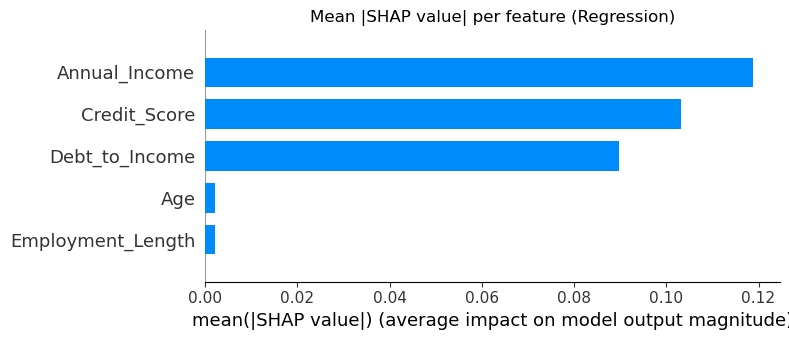

In [50]:
plt.figure(figsize=(6, 4))
shap.summary_plot(
    shap_values,
    X_test_scaled[:100],
    feature_names=X.columns,
    plot_type="bar",
    show=False
)
plt.title("Mean |SHAP value| per feature (Regression)")
plt.tight_layout()
plt.show()

In [48]:
def compute_feature_recovery_metrics(gt, ranking):
    """
    Compute TP, FP, FN, Precision, Recall, FDR, and Top-1 Match for feature recovery.

    Parameters
    ----------
    gt : set
        Ground-truth causal features.
    flagged : list or set
        Features your method flagged as important (e.g., top‑k from ranking).
    ranking : list
        Ordered list of features by descending effect size.

    Returns
    -------
    pd.DataFrame
        Single-row DataFrame with the metrics.
    """
    tp = set(gt) & set(ranking)
    fp = set(ranking) - set(gt)
    fn = set(gt) - set(ranking)

    precision = len(tp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    recall    = len(tp) / len(gt)        if len(gt)              else 0.0
    fdr       = len(fp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    top1      = 1 if ranking and ranking[0] in gt else 0

    metrics = {
        "TP":           ", ".join(sorted(tp)),
        "FP":           ", ".join(sorted(fp)),
        "FN":           ", ".join(sorted(fn)),
        "Precision":     precision,
        "Recall":        recall,
        "FDR":           fdr,
        "Top-1 Match":   top1
    }
    return pd.DataFrame([{
        "Precision": precision,
        "Recall": recall,
        "FDR": fdr,
        "Top-1 Match": top1
    }])



if __name__ == "__main__":
    # Example:
    GT = {"annual_income", "credit_score", "debt_to_income"}
    ranking = [
        "annual_income",
        "credit_score",
        "debt_to_income",
        "employment_length",
        "Age"
    ]
    # flagged = ranking[:3]  # e.g. top‑3 features

    df_metrics = compute_feature_recovery_metrics(GT, ranking)
    df_metrics.insert(0, "Method", "Stat-XAI")
    df_metrics = df_metrics[["Method", "Precision", "Recall", "FDR", "Top-1 Match"]]
    print(df_metrics.to_string(index=False))

  Method  Precision  Recall  FDR  Top-1 Match
Stat-XAI        0.6     1.0  0.4            1


In [60]:
mean_abs_shap = np.abs(shap_values).mean(axis=0)  

# 2) Build a DataFrame and sort descending
importance_df = pd.DataFrame({
    'feature': X.columns,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False)

# 3) Print it
print("Overall feature importances (by mean |SHAP|):")
print(importance_df.to_string(index=False))


Overall feature importances (by mean |SHAP|):
          feature  mean_abs_shap
    Annual_Income       0.118723
     Credit_Score       0.103157
   Debt_to_Income       0.089710
              Age       0.002193
Employment_Length       0.002040


In [30]:
import shap
import numpy as np
import psutil

In [34]:
explainer = shap.Explainer(mlp.predict, X_train_scaled)


In [36]:
shap_list = []
for start in range(0, len(X_test_scaled), 2000):
    Xb = X_test_scaled[start:start+2000]
    sv = explainer(Xb).values          # shape = (chunk_size, n_features)
    shap_list.append(sv)
all_shap = np.vstack(shap_list) 

In [40]:
feature_names = ["Annual_Income","Credit_Score","Debt_to_Income","Employment_Length","Age"]

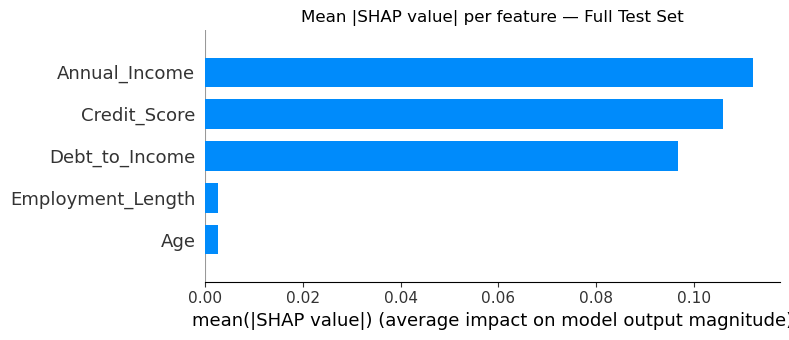

In [54]:
import os
os.makedirs("shap", exist_ok=True)

# 2) Create the figure
plt.figure(figsize=(8,6))


X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)
shap.summary_plot(
    all_shap,
    X_test_df,
    feature_names=feature_names,
    plot_type="bar",   # or omit for the default beeswarm
    show=False         # turn off immediate display
)

plt.title("Mean |SHAP value| per feature — Full Test Set")
plt.tight_layout()

# 5) Save to file (e.g. PNG or JPG)
out_path = os.path.join("shap", "numerical_regression_test_shap_summary.jpg")
plt.savefig(out_path, format="png", dpi=300)

# 6) Finally display in notebook
plt.show()

In [44]:
mean_shap = pd.Series(
    np.abs(all_shap).mean(axis=0),
    index=feature_names
).sort_values(ascending=False)

# Print them out
print("Mean |SHAP value| per feature (descending):")
print(mean_shap)

Mean |SHAP value| per feature (descending):
Annual_Income        0.112035
Credit_Score         0.106053
Debt_to_Income       0.096716
Employment_Length    0.002735
Age                  0.002637
dtype: float64


In [56]:
def compute_feature_recovery_metrics(gt, ranking):
    """
    Compute TP, FP, FN, Precision, Recall, FDR, and Top-1 Match for feature recovery.

    Parameters
    ----------
    gt : set
        Ground-truth causal features.
    flagged : list or set
        Features your method flagged as important (e.g., top‑k from ranking).
    ranking : list
        Ordered list of features by descending effect size.

    Returns
    -------
    pd.DataFrame
        Single-row DataFrame with the metrics.
    """
    tp = set(gt) & set(ranking)
    fp = set(ranking) - set(gt)
    fn = set(gt) - set(ranking)

    precision = len(tp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    recall    = len(tp) / len(gt)        if len(gt)              else 0.0
    fdr       = len(fp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    top1      = 1 if ranking and ranking[0] in gt else 0

    metrics = {
        "TP":           ", ".join(sorted(tp)),
        "FP":           ", ".join(sorted(fp)),
        "FN":           ", ".join(sorted(fn)),
        "Precision":     precision,
        "Recall":        recall,
        "FDR":           fdr,
        "Top-1 Match":   top1
    }
    return pd.DataFrame([{
        "Precision": precision,
        "Recall": recall,
        "FDR": fdr,
        "Top-1 Match": top1
    }])



if __name__ == "__main__":
    # Example:
    GT = {"annual_income", "credit_score", "debt_to_income"}
    ranking = [
        "annual_income",
        "credit_score",
        "debt_to_income",
        "employment_length",
        "Age"
        
    ]
    # flagged = ranking[:3]  # e.g. top‑3 features

    df_metrics = compute_feature_recovery_metrics(GT, ranking)
    df_metrics.insert(0, "Method", "SHAP-XAI")
    df_metrics = df_metrics[["Method", "Precision", "Recall", "FDR", "Top-1 Match"]]
    print(df_metrics.to_string(index=False))

  Method  Precision  Recall  FDR  Top-1 Match
SHAP-XAI        0.6     1.0  0.4            1
